# train Res-MLP

In [1]:
import numpy as np
import logging
import pickle
from datetime import datetime
import torch
from sklearn.metrics import root_mean_squared_error
import matplotlib.pyplot as plt
from lib.models import *
from lib.utils_dl import *

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
logging.basicConfig(filename='log/resmlp.log', level=logging.INFO, format='%(asctime)s - %(message)s')
logger = logging.getLogger()

In [2]:
Lt_simu = np.load('data/simulation_dataset/Lt_simu.npy')
Lg_simu = np.load('data/simulation_dataset/Lg_simu.npy')
Ld = np.load('data/simulation_dataset/Ld.npy')
vzas = np.load('data/simulation_dataset/vzas.npy')
tpw = np.load('data/simulation_dataset/tpw.npy')
num_atm, num_vza, num_lst, num_emi, num_channel  = Lt_simu.shape

Ld_simu = Ld[:,None,None,None,:] * np.ones_like(Lg_simu)
tpw_simu = tpw[:,None,None,None,None] * np.ones((num_atm, num_vza, num_lst, num_emi, 1))
vzas_simu = vzas[:,:,None,None,None] * np.ones((num_atm, num_vza, num_lst, num_emi, 1))
sec_vza = 1 / np.cos(np.deg2rad(vzas_simu))

# SW method input
dL_45 = (Lt_simu[..., 3] - Lt_simu[..., 4])[..., None]

# construct dataset
x = np.concatenate([Lt_simu[..., [1,3]], dL_45, sec_vza, tpw_simu], axis=-1) # np.concatenate([Lt_simu[..., [1,3,4]], sec_vza, tpw_simu], axis=-1)
y = np.concatenate([Lg_simu[...,[1,3,4]], Ld_simu[...,[1,3,4]]], axis=-1)
num_input, num_output = x.shape[-1], y.shape[-1]
str_input = 'w_tpw'
dataloader_train, dataloader_val, dataloader_test, idx_train, idx_val, idx_test, scaler, bin_edges = build_dataset(x, y, batch_size_train=2048, batch_size_val=65536, n_bins=None)
# pickle.dump(scaler, open(f'result/scaler/scaler_3b_wo_tpw.pkl','wb'))
# pickle.dump(bin_edges, open(f'result/scaler/bin_edges_{len(bin_edges[0])-1}.pkl', 'wb'))
'''
idx = {}
idx['train'], idx['val'], idx['test'] = idx_train, idx_val, idx_test
pickle.dump(idx, open('result/idx.pkl','wb'))
'''

"\nidx = {}\nidx['train'], idx['val'], idx['test'] = idx_train, idx_val, idx_test\npickle.dump(idx, open('result/idx.pkl','wb'))\n"

In [ ]:
## train model
# on different devices with various versions of packages, the optimazation results may be slightly different while the final accuracy is believed to be similar
logger.info('='*50)
logger.info(f'input:{str_input}')
myseed = 0
set_seed(myseed)
# define model, loss function and optimizer
params_model = {'d_in': num_input, 'd_out': num_output//2, 'd_block':128, 'd_hidden':64, 'n_block_l':3, 'n_block_h':2, 'act':'sigmoid', 'skip': True}
model = Res_MLP(**params_model).to(device)
model.apply(weights_init)

save_path = f'model/res_mlp/model_{str_input}_{datetime.now().strftime("%Y%m%d%H%M")}.pt'
params_train = {'opt':'adamw', 'lr':1e-3, 'scheduler': 'plateau', 'weight_decay': 1e-2, 
                'num_epochs':500, 'patience':10, 'w1':5, 'w2':1, 'seed':myseed, 'save_path':save_path}
optimizer = get_optimizer(params_train['opt'], model, lr=params_train['lr'], weight_decay=params_train['weight_decay'])
loss_function = CustomLoss(w1=params_train['w1'], w2=params_train['w2'])
scheduler = get_scheduler(params_train['scheduler'], optimizer, factor=0.1, patience=5, min_lr=1e-5)

# log info
log_message1 = ''.join([f'{key}={value}, ' for key, value in params_model.items()])
log_message2 = ''.join([f'{key}={value}, ' for key, value in params_train.items()])
logger.info(log_message1)
logger.info(log_message2)

train_model(model, dataloader_train, dataloader_val, params_train['num_epochs'], params_train['patience'], optimizer, device, loss_function, scheduler, save_path, logger, params_train['seed'])

# ablation experiment

In [5]:
# read log file
import pandas as pd
file = 'log/resmlp.log'
with open(file, 'r') as f:
    lines = f.readlines()

In [6]:
loss_train_all, loss_val_all = [[], []], [[], []]

if_read, i = False, -1
for line in lines:
    # start reading
    if 'Epoch [1/500]' in line:
        if_read = True
        i += 1
    
    if 'stopping' in line:
        if_read = False

    if if_read:
        line = line.split()
        loss_train = float(line[5].split(':')[1].strip(','))
        loss_val = float(line[9].split(':')[1].strip(','))
        loss_train_all[i].append(loss_train)
        loss_val_all[i].append(loss_val)

num_1, num_2 = len(loss_train_all[0]), len(loss_train_all[1])

print(f'ResMLP reaches minumum val loss at epoch {num_1-10} with loss {loss_val_all[0][num_1-10]}')
print(f'MLP reaches minumum val loss at epoch {num_2-10} with loss {loss_val_all[1][num_2-10]}')

ResMLP reaches minumum val loss at epoch 50 with loss 0.3216
MLP reaches minumum val loss at epoch 84 with loss 0.3249


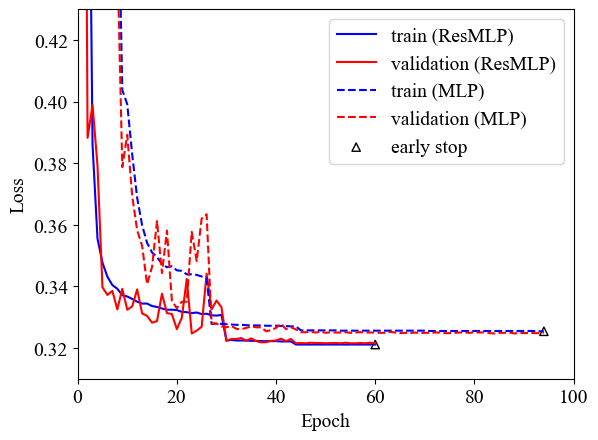

In [9]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 14

plt.plot(np.arange(1, num_1+1), loss_train_all[0], color='blue', label='train (ResMLP)')
plt.plot(np.arange(1, num_1+1), loss_val_all[0], color='red', label='validation (ResMLP)')
plt.plot(np.arange(1, num_2+1), loss_train_all[1], color='blue', linestyle='--', label='train (MLP)')
plt.plot(np.arange(1, num_2+1), loss_val_all[1], color='red', linestyle='--', label='validation (MLP)')

plt.scatter(num_1, loss_train_all[0][-1], edgecolor='black', facecolor='none', marker='^', label='early stop')
plt.scatter(num_2, loss_train_all[1][-1], edgecolor='black', facecolor='none', marker='^')

plt.xlim(0, 100)
plt.ylim(0.31, 0.43)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# plt.savefig('figs/resmlp_versus_mlp.tif', dpi=300, bbox_inches='tight')

# train CatBoost (using Optuna for optimization)

In [1]:
import numpy as np
import pickle
import logging
import joblib
from catboost import CatBoostRegressor, FeaturesData, Pool
import optuna
import optuna.visualization as vis
from lib.optuna_lab import early_stop_callback
from sklearn.metrics import root_mean_squared_error
# from optuna.integration import CatBoostPruningCallback

logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [ ]:
# read data
# the role of noise injection is similar to regularization, thus it is not used
Lt_simu = np.load('data/simulation_dataset/Lt_simu.npy')
Lg_simu = np.load('data/simulation_dataset/Lg_simu.npy')
Ld = np.load('data/simulation_dataset/Ld.npy')
vzas = np.load('data/simulation_dataset/vzas.npy')
tpw = np.load('data/simulation_dataset/tpw.npy')
num_atm, num_vza, num_lst, num_emi, num_channel  = Lt_simu.shape

Ld_simu = Ld[:,None,None,None,:] * np.ones_like(Lg_simu)
tpw_simu = tpw[:,None,None,None,None] * np.ones((num_atm, num_vza, num_lst, num_emi, 1))
vzas_simu = vzas[:,:,None,None,None] * np.ones((num_atm, num_vza, num_lst, num_emi, 1))
sec_vza = 1 / np.cos(np.deg2rad(vzas_simu))

# SW method input
dL_45 = (Lt_simu[..., 3] - Lt_simu[..., 4])[..., None]

idx = pickle.load(open('result/idx.pkl', 'rb'))

In [ ]:
# construct dataset and split
# order of input parameters: L1~L4, dL_45, secVZA, TPW
x = np.concatenate([Lt_simu[..., [1,3]], dL_45, sec_vza, tpw_simu], axis=-1)
y = np.concatenate([Lg_simu[...,[1,3,4]], Ld_simu[...,[1,3,4]]], axis=-1)
str_input = 'w_tpw_wo_noise'
num_input, num_output = x.shape[-1], y.shape[-1]

x_train, x_val, x_test = x[idx['train']].reshape(-1, num_input), x[idx['val']].reshape(-1, num_input), x[idx['test']].reshape(-1, num_input)
y_train, y_val, y_test = y[idx['train']].reshape(-1, num_output), y[idx['val']].reshape(-1, num_output), y[idx['test']].reshape(-1, num_output)

# construct pool
feature_data_train = FeaturesData(num_feature_data=x_train.astype(np.float32))
pool_train = Pool(data=feature_data_train, label=y_train)
feature_data_eval = FeaturesData(num_feature_data=x_val.astype(np.float32))
pool_eval = Pool(data=feature_data_eval, label=y_val)

In [ ]:
rmse_eval_min = np.Inf

# Since user-defined callback is not supported in CatBoost_GPU, we have to comment out the related codes, and no pruning is performed.
def objective_cb(trial):
    global rmse_eval_min

    params = {
        # fixed parameters
        "random_seed": 0,
        "loss_function": "MultiRMSE",
        "eval_metric": "MultiRMSE",
        "od_type": "Iter",
        "task_type": "GPU",
        "devices": "0",
        "allow_writing_files": False, # do not create catboost_info for log
        # search parameters
        "iterations": trial.suggest_int("iterations", 1000, 2000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3),
        "depth": trial.suggest_int("depth", 6, 10),
        # "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.2, 1), # cannot be used with GPU
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 0, 10),
        "random_strength": trial.suggest_float("random_strength", 0, 10),
    }

    # fit model
    model = CatBoostRegressor(**params)
    # pruning_callback = CatBoostPruningCallback(trial, "Accuracy")
    model.fit(pool_train, verbose=False, plot=False, early_stopping_rounds=10, eval_set=pool_eval) # , callbacks=[pruning_callback]

    # evoke pruning manually
    # pruning_callback.check_pruned()

    # get accuracy metric
    rmse_eval_min_trial = model.get_best_score()["validation"][params["eval_metric"]]

    # save best model
    if rmse_eval_min_trial<rmse_eval_min:
        rmse_eval_min = rmse_eval_min_trial
        model.save_model(f"model/catboost/model_{str_input}.cbm")
    
    return rmse_eval_min_trial

In [ ]:
fh = logging.FileHandler("log/catboost.log", mode="a")
logger.addHandler(fh)
logger.info('=' * 100)
optuna.logging.enable_propagation()
optuna.logging.disable_default_handler() 

SEED = 42
sampler = optuna.samplers.TPESampler(seed=SEED) # Tree-structured Parzen Estimator algorithm
# pruner = optuna.pruners.HyperbandPruner # suitable for TPESampler
study = optuna.create_study(sampler=sampler, direction='minimize')
early_stop = early_stop_callback(threshold=10)

logger.info(f"Start optimization, input: {str_input}, seed: {SEED}")
study.optimize(objective_cb, n_trials=30, callbacks=[early_stop])
logger.info(f"Best RMSE:{study.best_value:3f}")
logger.info(f"Best params:{study.best_params}")

joblib.dump(study, f"model/catboost/study_{str_input}.pkl")

logger.removeHandler(fh)

Early stop at 22th trial


In [ ]:
# history of optimization
# study = joblib.load('study.pkl')
vis.plot_optimization_history(study)

# visualize optimization process
# vis.plot_parallel_coordinate(study)

# importance of hyperparameters
# vis.plot_param_importances(study)